In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models.viewmaker import ViewMaker
from models.resnet import ResNetEncoder
from models.auto_aug import autoAUG
from models.resnet_1d import model_ResNet
from models.SimCLR import SimCLR
from models.linear_evaluation import LinearEvaResNet
from train import trainSimCLR, trainLinearEvalution
from torchinfo import summary

from utils.dataset import TransDataset
import configs

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

class SimCLR(nn.Module):
    def __init__(self, viewmaker_config, encoder_config):
        super().__init__()
        self.viewmaker_config = viewmaker_config
        self.view = self.create_viewmaker(viewmaker_config)
        self.encoder = self.create_encoder(encoder_config)
        self.fc = nn.Linear(512, 16)
        
    def create_viewmaker(self, viewmaker_config):
        view_model = ViewMaker(num_channels = viewmaker_config['num_channels'],
                               distortion_budget = viewmaker_config['view_bound_magnitude'],
                               clamp = viewmaker_config['clamp'])
        return view_model
    
    def create_encoder(self, encoder_config):
        encoder = model_ResNet([2,2,2,2], 
                    inchannel=configs.in_channel, 
                    num_classes=configs.num_classes)
        # encoder = ResNetEncoder(
        #                 in_channels=encoder_config['in_channels'], 
        #                 base_filters=encoder_config['base_filters'],
        #                 kernel_size=encoder_config['kernel_size'], 
        #                 stride=encoder_config['stride'], 
        #                 groups=1, 
        #                 n_block=encoder_config['n_block'], 
        #                 downsample_gap=encoder_config['downsample_gap'], 
        #                 increasefilter_gap=encoder_config['increasefilter_gap'], 
        #                 use_do=True)
        return encoder
    
    def forward(self, x1, x2):
        if self.viewmaker_config['use_leaves']:
            x1 = self.view(x1)
            x2 = self.view(x2)
        
        view1_emb = self.fc(self.encoder(x1))
        view2_emb = self.fc(self.encoder(x2))
        
        return view1_emb, view2_emb

def create_dataloader(is_training=True):
    trainSet = TransDataset(configs.filepath_train, is_training=is_training)
    testSet = TransDataset(configs.filepath_test, is_training=is_training)
    trainLoader = DataLoader(
        trainSet,
        batch_size=configs.batchsize,
        shuffle=True,
        drop_last=True)
    testLoader = DataLoader(
        testSet,
        batch_size=configs.batchsize,
        shuffle=True,
        drop_last=True)
    return trainLoader, testLoader

def create_model(pretrain, freeze_encoder=False):
    model = SimCLR(configs.viewmaker_configs, configs.encoder_configs)
    state_dict = torch.load('./experiments/sleep_apnea/normalization/checkpoint_130.pth')
    model_state = model.state_dict()
    pretrained_dict = {k: v for k, v in state_dict.items() if k in model_state}
    print(pretrained_dict.keys())
    model_state.update(pretrained_dict)
    model.load_state_dict(model_state)
    return model, state_dict

# trainLoader, testLoader = create_dataloader(is_training=False)
# trainSet = TransDataset(configs.filepath_train, is_training=is_training)
# testSet = TransDataset("/rdf/data/physionet.org/processed_DA/sleep_apnea/sleep_apnea_test.csv", is_training=True)
model, state_dict = create_model(pretrain=True)
# summary(model, ((256, 1, 3000), (256, 1, 3000)))
# trainSimCLR(model, trainLoader, testLoader, device)
# trainLinearEvalution(model, trainLoader, testLoader, device)

/rdf/user/hy29/viewmaker_physiological/models/resnet_1d.py:55: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)


dict_keys(['view.conv1.conv1d.weight', 'view.conv1.conv1d.bias', 'view.in1.weight', 'view.in1.bias', 'view.conv2.conv1d.weight', 'view.conv2.conv1d.bias', 'view.in2.weight', 'view.in2.bias', 'view.conv3.conv1d.weight', 'view.conv3.conv1d.bias', 'view.in3.weight', 'view.in3.bias', 'view.res1.conv1.conv1d.weight', 'view.res1.conv1.conv1d.bias', 'view.res1.in1.weight', 'view.res1.in1.bias', 'view.res1.conv2.conv1d.weight', 'view.res1.conv2.conv1d.bias', 'view.res1.in2.weight', 'view.res1.in2.bias', 'view.res2.conv1.conv1d.weight', 'view.res2.conv1.conv1d.bias', 'view.res2.in1.weight', 'view.res2.in1.bias', 'view.res2.conv2.conv1d.weight', 'view.res2.conv2.conv1d.bias', 'view.res2.in2.weight', 'view.res2.in2.bias', 'view.res3.conv1.conv1d.weight', 'view.res3.conv1.conv1d.bias', 'view.res3.in1.weight', 'view.res3.in1.bias', 'view.res3.conv2.conv1d.weight', 'view.res3.conv2.conv1d.bias', 'view.res3.in2.weight', 'view.res3.in2.bias', 'view.res4.conv1.conv1d.weight', 'view.res4.conv1.conv1d.bi

In [42]:
import neurokit2 as nk
from collections import Counter

In [45]:
model.view.parameters()

pp=0
for p in list(model.view.parameters()):
    nn=1
    for s in list(p.size()):
        nn = nn*s
    pp += nn

In [46]:
pp

582661

In [20]:
def l2_normalize(x, dim=2):
    return x / torch.sqrt(torch.sum(x**2, dim=dim).unsqueeze(dim))

def normalize(arr):
    max_arr = arr.max()
    min_arr = arr.min()
    norm_arr = (arr - min_arr) / (max_arr - min_arr)
    
    return norm_arr

In [41]:
import matplotlib.pyplot as plt
quality = []
for i in tqdm(range(2000)):
    try:
        data_test = normalize(testSet.__getitem__(i)[0].ravel())
        # data_test = testSet.__getitem__(1)[0].ravel()
        data_test = torch.Tensor(data_test.reshape(1,1,6000))
        data_test_view = model.view(data_test)
        quality.append(nk.ecg_quality(data_test_view[0][0].detach().numpy(), method="zhao2018", approach='fuzzy'))
    except:
        quality.append("Unnacceptable")

/home/hy29/anaconda3/envs/general_dl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hy29/anaconda3/envs/general_dl/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
nk.ecg_quality(data_test_view[0][0].detach().numpy(), method="zhao2018", approach='fuzzy')

'Unnacceptable'

In [34]:
data_test_view[0][0][:500].detach().numpy()

array([0.0677866 , 0.08210433, 0.2610756 , 0.5884475 , 0.8572712 ,
       0.8248104 , 0.45738143, 0.1433255 , 0.07689052, 0.08600777,
       0.08920851, 0.09872298, 0.10328406, 0.10892212, 0.12146758,
       0.13328446, 0.14365831, 0.15137586, 0.16405478, 0.17884998,
       0.17309707, 0.15129557, 0.13354252, 0.1292612 , 0.13550758,
       0.14817762, 0.1606003 , 0.17090374, 0.18150938, 0.19084165,
       0.19935583, 0.20802099, 0.21137798, 0.20539525, 0.19074702,
       0.175048  , 0.15975134, 0.15192172, 0.1574083 , 0.1656681 ,
       0.17610514, 0.18912564, 0.19745575, 0.20043454, 0.20178437,
       0.19282433, 0.17236659, 0.1578851 , 0.15119213, 0.14966954,
       0.15238217, 0.15840693, 0.16892692, 0.17970686, 0.18687046,
       0.19159204, 0.19428691, 0.1954087 , 0.19705251, 0.2014844 ,
       0.20320748, 0.19847143, 0.19203117, 0.18785065, 0.1846155 ,
       0.1779927 , 0.16648658, 0.15325701, 0.1424554 , 0.14302059,
       0.15041232, 0.15701714, 0.16484699, 0.17082593, 0.17122

In [15]:
import utils.augmentation as aug
import numpy as np

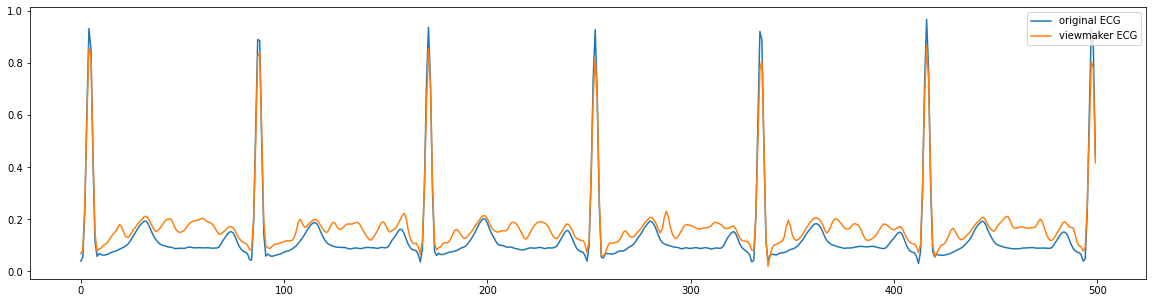

In [32]:
plt.figure(figsize=(20,5))
plt.plot(data_test.numpy().ravel()[:500], label='original ECG')
plt.plot(data_test_view[0][0][:500].detach().numpy(), label='viewmaker ECG')
plt.legend()


In [45]:
aug_test = data_test.numpy().ravel().reshape((1,-1))

In [46]:
(aug_test - np.min(aug_test, axis=1, keepdims=True))/(np.max(aug_test, axis=1, keepdims=True) - np.min(aug_test, axis=1, keepdims=True) + 0.00000001)

array([[0.7708135 , 0.7897727 , 0.7448559 , ..., 0.54667586, 0.5524672 ,
        0.491636  ]], dtype=float32)

In [47]:
plt.figure(figsize=(20,5))
plt.plot(aug.magnitude_warp(aug_test).ravel()[:500])

ValueError: `x` must be strictly increasing sequence.

<Figure size 1440x360 with 0 Axes>

In [35]:
normalize(testSet.__getitem__(1)[0].ravel())

array([0.98620688, 1.        , 0.96354679, ..., 0.66699507, 0.67192118,
       0.64433498])

In [43]:
data_test = testSet.__getitem__(1)[0]

In [43]:
data_test.reshape((-1,1))
(data_test.reshape((-1,1)) - np.min(data_test.reshape((-1,1)), axis=1, keepdims=True))/(np.max(data_test.reshape((-1,1)), axis=1, keepdims=True) - np.min(data_test.reshape((-1,1)), axis=1, keepdims=True) + 0.00000001)

TypeError: min() received an invalid combination of arguments - got (keepdims=bool, axis=int, out=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
 * (name dim, bool keepdim)


In [55]:
data_test - np.min(data_test, axis=1, keepdims=True)

array([[9.53769312, 9.6710876 , 9.31854539, ..., 6.45056779, 6.49820864,
        6.23142001]])

In [57]:
((data_test - np.min(data_test, axis=1, keepdims=True))/(np.max(data_test, axis=1, keepdims=True) - np.min(data_test, axis=1, keepdims=True) +                 0.00000001)).shape

(1, 3000)

 ...]

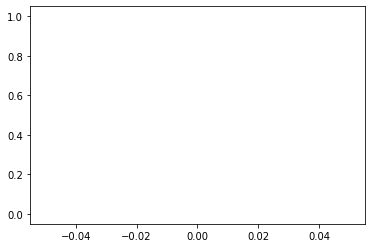

In [49]:
import numpy as np
plt.plot((data_test - np.min(data_test, axis=1, keepdims=True))/(np.max(data_test, axis=1, keepdims=True) - np.min(data_test, axis=1, keepdims=True) +                 0.00000001).ravel())

## LEAVES

This directory contains the example codes for the LEAVES as supplementary materials that submitted to ICLR 2023.

The major contribution componenet is the LEAVES module with the differentiable augmentation methods, which programed in ./models/augo_aug.py and ./utils/differentiable_augs.py, respectively.

The datasets used in this study:
- Apnea-ECG: https://physionet.org/content/apnea-ecg/1.0.0/
- Sleep-EDFE: https://www.physionet.org/content/sleep-edfx/1.0.0/
- PAMAP2: https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring
- PTB-XL: https://physionet.org/content/ptb-xl/1.0.2/

The python environment used in this work can be found in environment.yml

Command of 'run main.py' can be used to run the projects. The settings, such as path of the dataset, hyper-parameters, can be found in configs.py file.